In [1]:
from __future__ import print_function
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np

In [18]:
epochs = 100
batch_size = 64
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 2e-3
beta1 = 0.5

In [3]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

In [6]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    data = mx.image.imresize(data, target_wd, target_ht)
    data = nd.transpose(data, (2, 0, 1))
    data = data.astype(np.float32)/127.5 - 1
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)

train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list),
                              batch_size=batch_size)

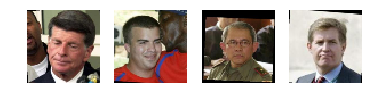

In [11]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1, 4, i+1)
    visualize(img_list[i + 10][0])
plt.show()

In [13]:
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

In [14]:
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [19]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    # fake_img = fake[0]
    # visualize(fake_img)
    # plt.show()

INFO:root:speed: 2768.28908506 samples/s
INFO:root:discriminator loss = 2.643891, generator loss = 1.635205, binary training acc = 0.554688 at iter 0 epoch 0
INFO:root:speed: 1106.12017373 samples/s
INFO:root:discriminator loss = 0.923536, generator loss = 2.653930, binary training acc = 0.668324 at iter 10 epoch 0
INFO:root:speed: 1037.32748014 samples/s
INFO:root:discriminator loss = 1.140160, generator loss = 1.721744, binary training acc = 0.659598 at iter 20 epoch 0
INFO:root:speed: 1082.67170018 samples/s
INFO:root:discriminator loss = 1.490861, generator loss = 4.172972, binary training acc = 0.668347 at iter 30 epoch 0
INFO:root:speed: 1107.97378197 samples/s
INFO:root:discriminator loss = 1.071184, generator loss = 5.428751, binary training acc = 0.669398 at iter 40 epoch 0
INFO:root:speed: 1078.56516743 samples/s
INFO:root:discriminator loss = 1.784591, generator loss = 3.922270, binary training acc = 0.660080 at iter 50 epoch 0
INFO:root:speed: 1104.00026321 samples/s
INFO:r

INFO:root:speed: 1055.75596537 samples/s
INFO:root:discriminator loss = 1.375107, generator loss = 1.990834, binary training acc = 0.671798 at iter 100 epoch 2
INFO:root:speed: 1003.62459528 samples/s
INFO:root:discriminator loss = 0.809875, generator loss = 3.499179, binary training acc = 0.678209 at iter 110 epoch 2
INFO:root:speed: 1093.09841066 samples/s
INFO:root:discriminator loss = 0.866933, generator loss = 2.613137, binary training acc = 0.678913 at iter 120 epoch 2
INFO:root:speed: 1002.74356838 samples/s
INFO:root:discriminator loss = 0.940103, generator loss = 3.017492, binary training acc = 0.678495 at iter 130 epoch 2
INFO:root:speed: 1104.62720053 samples/s
INFO:root:discriminator loss = 1.216116, generator loss = 3.158750, binary training acc = 0.678690 at iter 140 epoch 2
INFO:root:speed: 1105.71922396 samples/s
INFO:root:discriminator loss = 1.092870, generator loss = 1.909897, binary training acc = 0.676842 at iter 150 epoch 2
INFO:root:speed: 1122.94477214 samples/s

INFO:root:speed: 1076.53651279 samples/s
INFO:root:discriminator loss = 1.013924, generator loss = 3.736323, binary training acc = 0.710588 at iter 200 epoch 4
INFO:root:speed: 1096.15154621 samples/s
INFO:root:discriminator loss = 0.581534, generator loss = 3.507966, binary training acc = 0.890625 at iter 0 epoch 5
INFO:root:speed: 1117.68937003 samples/s
INFO:root:discriminator loss = 0.906581, generator loss = 2.586891, binary training acc = 0.733665 at iter 10 epoch 5
INFO:root:speed: 1095.27046017 samples/s
INFO:root:discriminator loss = 1.616698, generator loss = 1.527014, binary training acc = 0.737351 at iter 20 epoch 5
INFO:root:speed: 1003.22700432 samples/s
INFO:root:discriminator loss = 0.765474, generator loss = 2.990002, binary training acc = 0.733871 at iter 30 epoch 5
INFO:root:speed: 1092.80470935 samples/s
INFO:root:discriminator loss = 1.013348, generator loss = 4.685218, binary training acc = 0.721418 at iter 40 epoch 5
INFO:root:speed: 1039.17873914 samples/s
INFO:

INFO:root:speed: 1103.06572319 samples/s
INFO:root:discriminator loss = 1.011708, generator loss = 3.023253, binary training acc = 0.713685 at iter 90 epoch 7
INFO:root:speed: 1125.00138721 samples/s
INFO:root:discriminator loss = 0.886434, generator loss = 2.597459, binary training acc = 0.713567 at iter 100 epoch 7
INFO:root:speed: 1095.42242463 samples/s
INFO:root:discriminator loss = 0.932462, generator loss = 1.847501, binary training acc = 0.710374 at iter 110 epoch 7
INFO:root:speed: 1090.70002804 samples/s
INFO:root:discriminator loss = 1.065901, generator loss = 3.528523, binary training acc = 0.710808 at iter 120 epoch 7
INFO:root:speed: 1094.76570459 samples/s
INFO:root:discriminator loss = 1.212654, generator loss = 2.597455, binary training acc = 0.708254 at iter 130 epoch 7
INFO:root:speed: 1107.51208242 samples/s
INFO:root:discriminator loss = 1.682342, generator loss = 1.025951, binary training acc = 0.711215 at iter 140 epoch 7
INFO:root:speed: 1088.34303415 samples/s


INFO:root:speed: 1094.07409702 samples/s
INFO:root:discriminator loss = 1.361946, generator loss = 3.816226, binary training acc = 0.711878 at iter 190 epoch 9
INFO:root:speed: 1098.3357583 samples/s
INFO:root:discriminator loss = 1.154094, generator loss = 3.318267, binary training acc = 0.709461 at iter 200 epoch 9
INFO:root:speed: 1089.02741277 samples/s
INFO:root:discriminator loss = 0.780434, generator loss = 1.941222, binary training acc = 0.765625 at iter 0 epoch 10
INFO:root:speed: 1089.17764965 samples/s
INFO:root:discriminator loss = 1.087971, generator loss = 2.916279, binary training acc = 0.728693 at iter 10 epoch 10
INFO:root:speed: 1086.91963769 samples/s
INFO:root:discriminator loss = 1.488753, generator loss = 1.379610, binary training acc = 0.723586 at iter 20 epoch 10
INFO:root:speed: 1100.09120863 samples/s
INFO:root:discriminator loss = 1.037678, generator loss = 1.698520, binary training acc = 0.703881 at iter 30 epoch 10
INFO:root:speed: 1099.10926586 samples/s
I

INFO:root:discriminator loss = 0.978176, generator loss = 1.905077, binary training acc = 0.720180 at iter 70 epoch 12
INFO:root:speed: 1100.22647572 samples/s
INFO:root:discriminator loss = 1.115715, generator loss = 1.333468, binary training acc = 0.717110 at iter 80 epoch 12
INFO:root:speed: 1117.61491511 samples/s
INFO:root:discriminator loss = 0.968372, generator loss = 2.430876, binary training acc = 0.717548 at iter 90 epoch 12
INFO:root:speed: 952.919282352 samples/s
INFO:root:discriminator loss = 0.895705, generator loss = 2.149159, binary training acc = 0.719137 at iter 100 epoch 12
INFO:root:speed: 1103.69613716 samples/s
INFO:root:discriminator loss = 0.866709, generator loss = 2.485088, binary training acc = 0.721917 at iter 110 epoch 12
INFO:root:speed: 1009.40250813 samples/s
INFO:root:discriminator loss = 0.961092, generator loss = 2.930721, binary training acc = 0.723528 at iter 120 epoch 12
INFO:root:speed: 991.140199753 samples/s
INFO:root:discriminator loss = 1.1551

INFO:root:speed: 1086.14560683 samples/s
INFO:root:discriminator loss = 1.282972, generator loss = 4.358795, binary training acc = 0.714638 at iter 170 epoch 14
INFO:root:speed: 1101.0026496 samples/s
INFO:root:discriminator loss = 0.919474, generator loss = 2.103341, binary training acc = 0.715815 at iter 180 epoch 14
INFO:root:speed: 1096.56798314 samples/s
INFO:root:discriminator loss = 1.144776, generator loss = 1.704715, binary training acc = 0.714210 at iter 190 epoch 14
INFO:root:speed: 1087.56697539 samples/s
INFO:root:discriminator loss = 1.242380, generator loss = 2.123930, binary training acc = 0.714280 at iter 200 epoch 14
INFO:root:speed: 1131.05938963 samples/s
INFO:root:discriminator loss = 0.953541, generator loss = 2.029839, binary training acc = 0.750000 at iter 0 epoch 15
INFO:root:speed: 1090.88619138 samples/s
INFO:root:discriminator loss = 1.061139, generator loss = 3.162681, binary training acc = 0.743608 at iter 10 epoch 15
INFO:root:speed: 1094.46664438 samples

INFO:root:discriminator loss = 1.077836, generator loss = 1.872984, binary training acc = 0.734681 at iter 50 epoch 17
INFO:root:speed: 1057.10302243 samples/s
INFO:root:discriminator loss = 0.847594, generator loss = 2.910426, binary training acc = 0.744237 at iter 60 epoch 17
INFO:root:speed: 1085.32001795 samples/s
INFO:root:discriminator loss = 0.846992, generator loss = 4.123004, binary training acc = 0.749230 at iter 70 epoch 17
INFO:root:speed: 1003.18201387 samples/s
INFO:root:discriminator loss = 0.976103, generator loss = 1.756364, binary training acc = 0.742188 at iter 80 epoch 17
INFO:root:speed: 1060.60307313 samples/s
INFO:root:discriminator loss = 0.871586, generator loss = 2.282074, binary training acc = 0.741415 at iter 90 epoch 17
INFO:root:speed: 1004.2816855 samples/s
INFO:root:discriminator loss = 0.823863, generator loss = 2.460305, binary training acc = 0.740408 at iter 100 epoch 17
INFO:root:speed: 1023.77348762 samples/s
INFO:root:discriminator loss = 1.427087,

INFO:root:speed: 1020.13185477 samples/s
INFO:root:discriminator loss = 1.197386, generator loss = 1.408483, binary training acc = 0.739445 at iter 150 epoch 19
INFO:root:speed: 1057.6569767 samples/s
INFO:root:discriminator loss = 0.608287, generator loss = 2.594469, binary training acc = 0.739761 at iter 160 epoch 19
INFO:root:speed: 1007.22092522 samples/s
INFO:root:discriminator loss = 1.107843, generator loss = 4.356130, binary training acc = 0.744472 at iter 170 epoch 19
INFO:root:speed: 998.781290579 samples/s
INFO:root:discriminator loss = 0.875194, generator loss = 3.123625, binary training acc = 0.743051 at iter 180 epoch 19
INFO:root:speed: 1005.07133042 samples/s
INFO:root:discriminator loss = 0.837318, generator loss = 3.580851, binary training acc = 0.744028 at iter 190 epoch 19
INFO:root:speed: 1074.47246528 samples/s
INFO:root:discriminator loss = 0.808451, generator loss = 2.642303, binary training acc = 0.743781 at iter 200 epoch 19
INFO:root:speed: 989.70042289 sampl

INFO:root:discriminator loss = 0.892024, generator loss = 2.322724, binary training acc = 0.775454 at iter 30 epoch 22
INFO:root:speed: 1078.36585679 samples/s
INFO:root:discriminator loss = 0.664968, generator loss = 4.699500, binary training acc = 0.778963 at iter 40 epoch 22
INFO:root:speed: 1067.5542794 samples/s
INFO:root:discriminator loss = 0.832684, generator loss = 3.288402, binary training acc = 0.773897 at iter 50 epoch 22
INFO:root:speed: 1103.56001562 samples/s
INFO:root:discriminator loss = 1.348157, generator loss = 1.143753, binary training acc = 0.774590 at iter 60 epoch 22
INFO:root:speed: 1094.67195172 samples/s
INFO:root:discriminator loss = 1.284613, generator loss = 1.548590, binary training acc = 0.769146 at iter 70 epoch 22
INFO:root:speed: 1126.85737314 samples/s
INFO:root:discriminator loss = 0.967430, generator loss = 3.456526, binary training acc = 0.768422 at iter 80 epoch 22
INFO:root:speed: 1073.26529421 samples/s
INFO:root:discriminator loss = 0.849371, 

INFO:root:speed: 996.837782737 samples/s
INFO:root:discriminator loss = 0.728253, generator loss = 2.622957, binary training acc = 0.794549 at iter 130 epoch 24
INFO:root:speed: 1054.29638154 samples/s
INFO:root:discriminator loss = 0.702867, generator loss = 3.603311, binary training acc = 0.796432 at iter 140 epoch 24
INFO:root:speed: 991.557566646 samples/s
INFO:root:discriminator loss = 0.434240, generator loss = 3.832041, binary training acc = 0.794857 at iter 150 epoch 24
INFO:root:speed: 940.140358005 samples/s
INFO:root:discriminator loss = 0.574303, generator loss = 3.169729, binary training acc = 0.793575 at iter 160 epoch 24
INFO:root:speed: 883.685760185 samples/s
INFO:root:discriminator loss = 1.461376, generator loss = 6.151237, binary training acc = 0.797149 at iter 170 epoch 24
INFO:root:speed: 1099.58200102 samples/s
INFO:root:discriminator loss = 1.061985, generator loss = 5.119555, binary training acc = 0.795321 at iter 180 epoch 24
INFO:root:speed: 1084.32045435 sam

INFO:root:discriminator loss = 0.759473, generator loss = 2.500856, binary training acc = 0.819602 at iter 10 epoch 27
INFO:root:speed: 1093.96262924 samples/s
INFO:root:discriminator loss = 0.985088, generator loss = 1.992131, binary training acc = 0.835193 at iter 20 epoch 27
INFO:root:speed: 1097.39283437 samples/s
INFO:root:discriminator loss = 0.628007, generator loss = 2.655272, binary training acc = 0.833417 at iter 30 epoch 27
INFO:root:speed: 1098.01228761 samples/s
INFO:root:discriminator loss = 1.081487, generator loss = 5.619515, binary training acc = 0.824505 at iter 40 epoch 27
INFO:root:speed: 1084.52635406 samples/s
INFO:root:discriminator loss = 0.814464, generator loss = 4.333580, binary training acc = 0.806373 at iter 50 epoch 27
INFO:root:speed: 1091.96452804 samples/s
INFO:root:discriminator loss = 0.760347, generator loss = 3.662777, binary training acc = 0.804175 at iter 60 epoch 27
INFO:root:speed: 1102.64886669 samples/s
INFO:root:discriminator loss = 0.659204,

INFO:root:speed: 1093.64618456 samples/s
INFO:root:discriminator loss = 0.622606, generator loss = 2.777310, binary training acc = 0.828758 at iter 110 epoch 29
INFO:root:speed: 1077.45689538 samples/s
INFO:root:discriminator loss = 0.430432, generator loss = 4.158129, binary training acc = 0.830708 at iter 120 epoch 29
INFO:root:speed: 1076.92953542 samples/s
INFO:root:discriminator loss = 0.716751, generator loss = 2.153362, binary training acc = 0.831942 at iter 130 epoch 29
INFO:root:speed: 1086.05332449 samples/s
INFO:root:discriminator loss = 0.499552, generator loss = 4.086900, binary training acc = 0.834885 at iter 140 epoch 29
INFO:root:speed: 1068.20000239 samples/s
INFO:root:discriminator loss = 0.601579, generator loss = 2.623388, binary training acc = 0.835627 at iter 150 epoch 29
INFO:root:speed: 1090.90392454 samples/s
INFO:root:discriminator loss = 0.665987, generator loss = 6.710723, binary training acc = 0.839431 at iter 160 epoch 29
INFO:root:speed: 1072.24497002 sam

INFO:root:discriminator loss = 0.604230, generator loss = 1.758270, binary training acc = 0.846315 at iter 200 epoch 31
INFO:root:speed: 1092.70684398 samples/s
INFO:root:discriminator loss = 0.444844, generator loss = 3.977052, binary training acc = 0.945312 at iter 0 epoch 32
INFO:root:speed: 1097.52743865 samples/s
INFO:root:discriminator loss = 0.403014, generator loss = 3.482245, binary training acc = 0.907670 at iter 10 epoch 32
INFO:root:speed: 989.499771457 samples/s
INFO:root:discriminator loss = 0.899972, generator loss = 5.760531, binary training acc = 0.898065 at iter 20 epoch 32
INFO:root:speed: 1083.11291696 samples/s
INFO:root:discriminator loss = 0.751186, generator loss = 2.274535, binary training acc = 0.854587 at iter 30 epoch 32
INFO:root:speed: 962.810633994 samples/s
INFO:root:discriminator loss = 1.085771, generator loss = 6.980621, binary training acc = 0.850610 at iter 40 epoch 32
INFO:root:speed: 1110.41666563 samples/s
INFO:root:discriminator loss = 0.598751,

INFO:root:speed: 1052.6632942 samples/s
INFO:root:discriminator loss = 0.905598, generator loss = 7.096870, binary training acc = 0.859203 at iter 90 epoch 34
INFO:root:speed: 1085.75900466 samples/s
INFO:root:discriminator loss = 0.414607, generator loss = 3.573736, binary training acc = 0.858601 at iter 100 epoch 34
INFO:root:speed: 1097.97635818 samples/s
INFO:root:discriminator loss = 0.482342, generator loss = 4.293019, binary training acc = 0.862120 at iter 110 epoch 34
INFO:root:speed: 1086.99446046 samples/s
INFO:root:discriminator loss = 0.677595, generator loss = 2.271904, binary training acc = 0.863830 at iter 120 epoch 34
INFO:root:speed: 1053.20433938 samples/s
INFO:root:discriminator loss = 0.460858, generator loss = 5.682252, binary training acc = 0.867307 at iter 130 epoch 34
INFO:root:speed: 1093.09841066 samples/s
INFO:root:discriminator loss = 0.467106, generator loss = 3.421381, binary training acc = 0.870900 at iter 140 epoch 34
INFO:root:speed: 1098.90229085 sampl

INFO:root:discriminator loss = 0.356946, generator loss = 2.482992, binary training acc = 0.884755 at iter 180 epoch 36
INFO:root:speed: 1065.86719715 samples/s
INFO:root:discriminator loss = 0.471051, generator loss = 4.174420, binary training acc = 0.883590 at iter 190 epoch 36
INFO:root:speed: 1099.88386367 samples/s
INFO:root:discriminator loss = 0.594467, generator loss = 6.312715, binary training acc = 0.885456 at iter 200 epoch 36
INFO:root:speed: 1070.02242605 samples/s
INFO:root:discriminator loss = 0.190210, generator loss = 4.047265, binary training acc = 0.968750 at iter 0 epoch 37
INFO:root:speed: 1090.17733754 samples/s
INFO:root:discriminator loss = 0.301273, generator loss = 4.707989, binary training acc = 0.950284 at iter 10 epoch 37
INFO:root:speed: 1104.64992901 samples/s
INFO:root:discriminator loss = 0.358244, generator loss = 4.937856, binary training acc = 0.956101 at iter 20 epoch 37
INFO:root:speed: 1093.26758303 samples/s
INFO:root:discriminator loss = 0.58477

INFO:root:speed: 1080.64063381 samples/s
INFO:root:discriminator loss = 0.385033, generator loss = 4.559009, binary training acc = 0.873790 at iter 70 epoch 39
INFO:root:speed: 1114.53838712 samples/s
INFO:root:discriminator loss = 0.454019, generator loss = 4.346823, binary training acc = 0.875289 at iter 80 epoch 39
INFO:root:speed: 1096.5859015 samples/s
INFO:root:discriminator loss = 0.405180, generator loss = 3.729377, binary training acc = 0.879378 at iter 90 epoch 39
INFO:root:speed: 1102.26853365 samples/s
INFO:root:discriminator loss = 0.388021, generator loss = 4.579249, binary training acc = 0.884514 at iter 100 epoch 39
INFO:root:speed: 942.785189972 samples/s
INFO:root:discriminator loss = 0.288875, generator loss = 3.692691, binary training acc = 0.887880 at iter 110 epoch 39
INFO:root:speed: 1081.00618557 samples/s
INFO:root:discriminator loss = 0.346145, generator loss = 3.380157, binary training acc = 0.891464 at iter 120 epoch 39
INFO:root:speed: 1081.66393063 samples

INFO:root:discriminator loss = 0.302419, generator loss = 3.675696, binary training acc = 0.909064 at iter 160 epoch 41
INFO:root:speed: 1082.30502133 samples/s
INFO:root:discriminator loss = 0.262832, generator loss = 5.425555, binary training acc = 0.913057 at iter 170 epoch 41
INFO:root:speed: 1098.97877253 samples/s
INFO:root:discriminator loss = 0.397195, generator loss = 3.579806, binary training acc = 0.912206 at iter 180 epoch 41
INFO:root:speed: 1079.23730033 samples/s
INFO:root:discriminator loss = 0.212597, generator loss = 4.736790, binary training acc = 0.914512 at iter 190 epoch 41
INFO:root:speed: 1117.61491511 samples/s
INFO:root:discriminator loss = 0.233035, generator loss = 4.042056, binary training acc = 0.913479 at iter 200 epoch 41
INFO:root:speed: 1090.70002804 samples/s
INFO:root:discriminator loss = 0.252204, generator loss = 4.784270, binary training acc = 0.929688 at iter 0 epoch 42
INFO:root:speed: 1103.14731893 samples/s
INFO:root:discriminator loss = 0.492

INFO:root:speed: 1096.19183273 samples/s
INFO:root:discriminator loss = 0.234002, generator loss = 4.381737, binary training acc = 0.926317 at iter 50 epoch 44
INFO:root:speed: 1092.15112333 samples/s
INFO:root:discriminator loss = 0.571046, generator loss = 5.089058, binary training acc = 0.915343 at iter 60 epoch 44
INFO:root:speed: 1080.87995522 samples/s
INFO:root:discriminator loss = 0.310030, generator loss = 4.949114, binary training acc = 0.909441 at iter 70 epoch 44
INFO:root:speed: 1081.82958195 samples/s
INFO:root:discriminator loss = 0.275947, generator loss = 3.163646, binary training acc = 0.904707 at iter 80 epoch 44
INFO:root:speed: 1100.52869237 samples/s
INFO:root:discriminator loss = 0.250132, generator loss = 4.135819, binary training acc = 0.904876 at iter 90 epoch 44
INFO:root:speed: 1082.3268405 samples/s
INFO:root:discriminator loss = 0.565312, generator loss = 8.610899, binary training acc = 0.906714 at iter 100 epoch 44
INFO:root:speed: 1094.7835641 samples/s


INFO:root:discriminator loss = 0.295702, generator loss = 6.224990, binary training acc = 0.920157 at iter 140 epoch 46
INFO:root:speed: 1136.14336202 samples/s
INFO:root:discriminator loss = 0.233260, generator loss = 5.134606, binary training acc = 0.922599 at iter 150 epoch 46
INFO:root:speed: 1092.85809785 samples/s
INFO:root:discriminator loss = 0.082908, generator loss = 6.015844, binary training acc = 0.925078 at iter 160 epoch 46
INFO:root:speed: 1090.90392454 samples/s
INFO:root:discriminator loss = 0.301776, generator loss = 3.022777, binary training acc = 0.928545 at iter 170 epoch 46
INFO:root:speed: 1058.42848074 samples/s
INFO:root:discriminator loss = 0.248020, generator loss = 3.358425, binary training acc = 0.929040 at iter 180 epoch 46
INFO:root:speed: 1068.39557255 samples/s
INFO:root:discriminator loss = 0.215458, generator loss = 5.506378, binary training acc = 0.930383 at iter 190 epoch 46
INFO:root:speed: 1079.5150706 samples/s
INFO:root:discriminator loss = 0.54

INFO:root:speed: 1077.83760691 samples/s
INFO:root:discriminator loss = 0.558392, generator loss = 7.711214, binary training acc = 0.858871 at iter 30 epoch 49
INFO:root:speed: 1078.6431786 samples/s
INFO:root:discriminator loss = 0.646060, generator loss = 1.688912, binary training acc = 0.869665 at iter 40 epoch 49
INFO:root:speed: 1079.20692788 samples/s
INFO:root:discriminator loss = 0.541721, generator loss = 3.838417, binary training acc = 0.871477 at iter 50 epoch 49
INFO:root:speed: 1105.58260297 samples/s
INFO:root:discriminator loss = 0.283969, generator loss = 6.023731, binary training acc = 0.886783 at iter 60 epoch 49
INFO:root:speed: 990.269986314 samples/s
INFO:root:discriminator loss = 0.439666, generator loss = 4.867135, binary training acc = 0.894256 at iter 70 epoch 49
INFO:root:speed: 1105.84676735 samples/s
INFO:root:discriminator loss = 0.308821, generator loss = 5.276679, binary training acc = 0.902103 at iter 80 epoch 49
INFO:root:speed: 1022.72424763 samples/s


INFO:root:discriminator loss = 0.057030, generator loss = 4.171270, binary training acc = 0.976950 at iter 120 epoch 51
INFO:root:speed: 1094.05626065 samples/s
INFO:root:discriminator loss = 1.104092, generator loss = 0.547356, binary training acc = 0.970301 at iter 130 epoch 51
INFO:root:speed: 1131.82242348 samples/s
INFO:root:discriminator loss = 1.981475, generator loss = 1.754938, binary training acc = 0.939328 at iter 140 epoch 51
INFO:root:speed: 1055.7061403 samples/s
INFO:root:discriminator loss = 1.881411, generator loss = 2.292220, binary training acc = 0.919029 at iter 150 epoch 51
INFO:root:speed: 1063.49399586 samples/s
INFO:root:discriminator loss = 2.039372, generator loss = 1.641978, binary training acc = 0.897418 at iter 160 epoch 51
INFO:root:speed: 1076.62718486 samples/s
INFO:root:discriminator loss = 1.961118, generator loss = 1.451029, binary training acc = 0.883772 at iter 170 epoch 51
INFO:root:speed: 1094.65409585 samples/s
INFO:root:discriminator loss = 1.22

INFO:root:speed: 1104.59083689 samples/s
INFO:root:discriminator loss = 0.362759, generator loss = 5.256178, binary training acc = 0.927557 at iter 10 epoch 54
INFO:root:speed: 1056.35007634 samples/s
INFO:root:discriminator loss = 0.325183, generator loss = 2.968493, binary training acc = 0.915551 at iter 20 epoch 54
INFO:root:speed: 1084.8200059 samples/s
INFO:root:discriminator loss = 0.356779, generator loss = 5.048231, binary training acc = 0.911290 at iter 30 epoch 54
INFO:root:speed: 1040.78636455 samples/s
INFO:root:discriminator loss = 0.342058, generator loss = 4.963615, binary training acc = 0.914253 at iter 40 epoch 54
INFO:root:speed: 1083.88262989 samples/s
INFO:root:discriminator loss = 0.206893, generator loss = 6.088460, binary training acc = 0.922794 at iter 50 epoch 54
INFO:root:speed: 1099.87935704 samples/s
INFO:root:discriminator loss = 0.226635, generator loss = 5.198235, binary training acc = 0.926614 at iter 60 epoch 54
INFO:root:speed: 1091.96452804 samples/s


INFO:root:discriminator loss = 0.249994, generator loss = 6.716374, binary training acc = 0.925820 at iter 100 epoch 56
INFO:root:speed: 1085.88637724 samples/s
INFO:root:discriminator loss = 0.186763, generator loss = 5.885769, binary training acc = 0.929265 at iter 110 epoch 56
INFO:root:speed: 1092.35556279 samples/s
INFO:root:discriminator loss = 0.060233, generator loss = 5.724596, binary training acc = 0.932141 at iter 120 epoch 56
INFO:root:speed: 1067.20201008 samples/s
INFO:root:discriminator loss = 0.221611, generator loss = 5.811058, binary training acc = 0.932908 at iter 130 epoch 56
INFO:root:speed: 1003.35449917 samples/s
INFO:root:discriminator loss = 0.131520, generator loss = 4.993321, binary training acc = 0.934231 at iter 140 epoch 56
INFO:root:speed: 947.838535635 samples/s
INFO:root:discriminator loss = 0.207696, generator loss = 4.468272, binary training acc = 0.936258 at iter 150 epoch 56
INFO:root:speed: 1062.85815648 samples/s
INFO:root:discriminator loss = 0.1

INFO:root:speed: 1106.42563733 samples/s
INFO:root:discriminator loss = 0.289972, generator loss = 5.366997, binary training acc = 0.873717 at iter 200 epoch 58
INFO:root:speed: 1057.32370156 samples/s
INFO:root:discriminator loss = 0.157874, generator loss = 5.078007, binary training acc = 0.976562 at iter 0 epoch 59
INFO:root:speed: 1115.72429788 samples/s
INFO:root:discriminator loss = 0.183012, generator loss = 5.810144, binary training acc = 0.935369 at iter 10 epoch 59
INFO:root:speed: 1093.94033841 samples/s
INFO:root:discriminator loss = 0.182237, generator loss = 4.269615, binary training acc = 0.950149 at iter 20 epoch 59
INFO:root:speed: 1096.26793758 samples/s
INFO:root:discriminator loss = 0.286184, generator loss = 4.131814, binary training acc = 0.955645 at iter 30 epoch 59
INFO:root:speed: 1069.39153922 samples/s
INFO:root:discriminator loss = 0.101662, generator loss = 5.358531, binary training acc = 0.959794 at iter 40 epoch 59
INFO:root:speed: 1096.32166501 samples/s

INFO:root:discriminator loss = 0.128172, generator loss = 4.234001, binary training acc = 0.994213 at iter 80 epoch 61
INFO:root:speed: 1091.29419991 samples/s
INFO:root:discriminator loss = 0.082452, generator loss = 5.160235, binary training acc = 0.994162 at iter 90 epoch 61
INFO:root:speed: 1082.70663494 samples/s
INFO:root:discriminator loss = 0.128761, generator loss = 6.754578, binary training acc = 0.994508 at iter 100 epoch 61
INFO:root:speed: 1096.67998251 samples/s
INFO:root:discriminator loss = 0.166881, generator loss = 5.183737, binary training acc = 0.993877 at iter 110 epoch 61
INFO:root:speed: 1099.16327216 samples/s
INFO:root:discriminator loss = 0.052895, generator loss = 5.709731, binary training acc = 0.993802 at iter 120 epoch 61
INFO:root:speed: 1073.60869652 samples/s
INFO:root:discriminator loss = 0.075868, generator loss = 5.813192, binary training acc = 0.993559 at iter 130 epoch 61
INFO:root:speed: 1091.18329783 samples/s
INFO:root:discriminator loss = 0.228

INFO:root:speed: 1086.3126338 samples/s
INFO:root:discriminator loss = 0.311879, generator loss = 2.917531, binary training acc = 0.943629 at iter 180 epoch 63
INFO:root:speed: 1085.59214789 samples/s
INFO:root:discriminator loss = 0.192436, generator loss = 5.319088, binary training acc = 0.944372 at iter 190 epoch 63
INFO:root:speed: 1081.29793396 samples/s
INFO:root:discriminator loss = 0.154341, generator loss = 5.773545, binary training acc = 0.945351 at iter 200 epoch 63
INFO:root:speed: 1091.76023492 samples/s
INFO:root:discriminator loss = 0.121533, generator loss = 5.415772, binary training acc = 0.968750 at iter 0 epoch 64
INFO:root:speed: 1105.79210229 samples/s
INFO:root:discriminator loss = 0.177754, generator loss = 6.195590, binary training acc = 0.984375 at iter 10 epoch 64
INFO:root:speed: 1065.46106064 samples/s
INFO:root:discriminator loss = 0.163378, generator loss = 5.757138, binary training acc = 0.986235 at iter 20 epoch 64
INFO:root:speed: 1082.51015627 samples/

INFO:root:discriminator loss = 0.094899, generator loss = 4.589811, binary training acc = 0.995261 at iter 60 epoch 66
INFO:root:speed: 907.452895758 samples/s
INFO:root:discriminator loss = 0.033719, generator loss = 4.711855, binary training acc = 0.994278 at iter 70 epoch 66
INFO:root:speed: 1076.26458819 samples/s
INFO:root:discriminator loss = 0.096238, generator loss = 6.376778, binary training acc = 0.994309 at iter 80 epoch 66
INFO:root:speed: 1067.26989933 samples/s
INFO:root:discriminator loss = 0.060499, generator loss = 5.739712, binary training acc = 0.993990 at iter 90 epoch 66
INFO:root:speed: 1073.55287869 samples/s
INFO:root:discriminator loss = 0.739416, generator loss = 2.659102, binary training acc = 0.988397 at iter 100 epoch 66
INFO:root:speed: 1057.59030486 samples/s
INFO:root:discriminator loss = 0.489562, generator loss = 12.460571, binary training acc = 0.985923 at iter 110 epoch 66
INFO:root:speed: 906.888795795 samples/s
INFO:root:discriminator loss = 1.3456

INFO:root:speed: 1047.30777574 samples/s
INFO:root:discriminator loss = 0.072630, generator loss = 5.904314, binary training acc = 0.989227 at iter 160 epoch 68
INFO:root:speed: 1058.1489412 samples/s
INFO:root:discriminator loss = 0.071591, generator loss = 5.729729, binary training acc = 0.989675 at iter 170 epoch 68
INFO:root:speed: 1074.73057613 samples/s
INFO:root:discriminator loss = 0.083596, generator loss = 5.727467, binary training acc = 0.989684 at iter 180 epoch 68
INFO:root:speed: 1066.70159348 samples/s
INFO:root:discriminator loss = 0.135567, generator loss = 7.598067, binary training acc = 0.988997 at iter 190 epoch 68
INFO:root:speed: 1006.06956105 samples/s
INFO:root:discriminator loss = 0.155929, generator loss = 7.012593, binary training acc = 0.989117 at iter 200 epoch 68
INFO:root:speed: 1113.74301824 samples/s
INFO:root:discriminator loss = 0.103909, generator loss = 6.783546, binary training acc = 0.992188 at iter 0 epoch 69
INFO:root:speed: 1055.06298885 sample

INFO:root:discriminator loss = 0.125847, generator loss = 6.600342, binary training acc = 0.987614 at iter 40 epoch 71
INFO:root:speed: 1079.40220918 samples/s
INFO:root:discriminator loss = 0.068984, generator loss = 5.078076, binary training acc = 0.988817 at iter 50 epoch 71
INFO:root:speed: 1080.06234887 samples/s
INFO:root:discriminator loss = 0.295563, generator loss = 3.786909, binary training acc = 0.981557 at iter 60 epoch 71
INFO:root:speed: 1045.46003902 samples/s
INFO:root:discriminator loss = 0.146062, generator loss = 4.018402, binary training acc = 0.978873 at iter 70 epoch 71
INFO:root:speed: 999.923473493 samples/s
INFO:root:discriminator loss = 0.121669, generator loss = 3.733362, binary training acc = 0.975791 at iter 80 epoch 71
INFO:root:speed: 1090.88175818 samples/s
INFO:root:discriminator loss = 3.017054, generator loss = 0.241305, binary training acc = 0.962311 at iter 90 epoch 71
INFO:root:speed: 1053.29112355 samples/s
INFO:root:discriminator loss = 0.508845,

INFO:root:speed: 932.320058905 samples/s
INFO:root:discriminator loss = 0.251338, generator loss = 8.411015, binary training acc = 0.981605 at iter 140 epoch 73
INFO:root:speed: 1003.02457908 samples/s
INFO:root:discriminator loss = 0.063817, generator loss = 5.363983, binary training acc = 0.982254 at iter 150 epoch 73
INFO:root:speed: 1081.33713604 samples/s
INFO:root:discriminator loss = 0.100603, generator loss = 6.547425, binary training acc = 0.982822 at iter 160 epoch 73
INFO:root:speed: 1083.49763672 samples/s
INFO:root:discriminator loss = 0.095040, generator loss = 6.256081, binary training acc = 0.983370 at iter 170 epoch 73
INFO:root:speed: 1074.05974568 samples/s
INFO:root:discriminator loss = 0.204726, generator loss = 5.421402, binary training acc = 0.983339 at iter 180 epoch 73
INFO:root:speed: 1073.303916 samples/s
INFO:root:discriminator loss = 0.076305, generator loss = 6.344041, binary training acc = 0.983925 at iter 190 epoch 73
INFO:root:speed: 1100.43394989 sampl

INFO:root:discriminator loss = 1.947765, generator loss = 0.072804, binary training acc = 0.915551 at iter 20 epoch 76
INFO:root:speed: 1106.2158979 samples/s
INFO:root:discriminator loss = 0.313913, generator loss = 6.969630, binary training acc = 0.880796 at iter 30 epoch 76
INFO:root:speed: 1083.64635165 samples/s
INFO:root:discriminator loss = 0.330070, generator loss = 7.266859, binary training acc = 0.891768 at iter 40 epoch 76
INFO:root:speed: 1091.03250717 samples/s
INFO:root:discriminator loss = 0.171045, generator loss = 4.516594, binary training acc = 0.887714 at iter 50 epoch 76
INFO:root:speed: 1097.31657326 samples/s
INFO:root:discriminator loss = 0.349131, generator loss = 6.755578, binary training acc = 0.890497 at iter 60 epoch 76
INFO:root:speed: 1083.80823489 samples/s
INFO:root:discriminator loss = 0.293928, generator loss = 4.488301, binary training acc = 0.897557 at iter 70 epoch 76
INFO:root:speed: 1098.90229085 samples/s
INFO:root:discriminator loss = 0.265162, 

INFO:root:speed: 1075.5013442 samples/s
INFO:root:discriminator loss = 0.302068, generator loss = 5.150966, binary training acc = 0.917872 at iter 120 epoch 78
INFO:root:speed: 1094.97559065 samples/s
INFO:root:discriminator loss = 1.212482, generator loss = 1.224021, binary training acc = 0.914301 at iter 130 epoch 78
INFO:root:speed: 1047.47941998 samples/s
INFO:root:discriminator loss = 0.248002, generator loss = 7.923221, binary training acc = 0.914949 at iter 140 epoch 78
INFO:root:speed: 1059.13006561 samples/s
INFO:root:discriminator loss = 0.223502, generator loss = 7.648799, binary training acc = 0.917581 at iter 150 epoch 78
INFO:root:speed: 1091.60928477 samples/s
INFO:root:discriminator loss = 0.141695, generator loss = 7.408365, binary training acc = 0.919983 at iter 160 epoch 78
INFO:root:speed: 1109.31993289 samples/s
INFO:root:discriminator loss = 0.389186, generator loss = 8.231890, binary training acc = 0.921829 at iter 170 epoch 78
INFO:root:speed: 1073.60869652 samp

INFO:root:discriminator loss = 0.075357, generator loss = 7.154868, binary training acc = 1.000000 at iter 0 epoch 81
INFO:root:speed: 1075.59184197 samples/s
INFO:root:discriminator loss = 0.031649, generator loss = 7.050639, binary training acc = 0.997159 at iter 10 epoch 81
INFO:root:speed: 1088.04747216 samples/s
INFO:root:discriminator loss = 0.049986, generator loss = 6.954867, binary training acc = 0.996652 at iter 20 epoch 81
INFO:root:speed: 1052.35378566 samples/s
INFO:root:discriminator loss = 0.116625, generator loss = 6.521904, binary training acc = 0.993448 at iter 30 epoch 81
INFO:root:speed: 1084.74548217 samples/s
INFO:root:discriminator loss = 0.087298, generator loss = 7.179972, binary training acc = 0.991235 at iter 40 epoch 81
INFO:root:speed: 1092.78246568 samples/s
INFO:root:discriminator loss = 0.120282, generator loss = 5.675310, binary training acc = 0.991575 at iter 50 epoch 81
INFO:root:speed: 1083.05610652 samples/s
INFO:root:discriminator loss = 0.119684, 

INFO:root:speed: 1087.73003221 samples/s
INFO:root:discriminator loss = 0.177643, generator loss = 6.386550, binary training acc = 0.954131 at iter 100 epoch 83
INFO:root:speed: 1086.75242402 samples/s
INFO:root:discriminator loss = 0.088975, generator loss = 5.833504, binary training acc = 0.956785 at iter 110 epoch 83
INFO:root:speed: 1093.9225064 samples/s
INFO:root:discriminator loss = 0.061871, generator loss = 6.991529, binary training acc = 0.958871 at iter 120 epoch 83
INFO:root:speed: 1089.67726431 samples/s
INFO:root:discriminator loss = 0.199108, generator loss = 5.031639, binary training acc = 0.960103 at iter 130 epoch 83
INFO:root:speed: 1062.37862226 samples/s
INFO:root:discriminator loss = 0.108339, generator loss = 5.761007, binary training acc = 0.962267 at iter 140 epoch 83
INFO:root:speed: 1056.48727384 samples/s
INFO:root:discriminator loss = 0.086151, generator loss = 7.563707, binary training acc = 0.958661 at iter 150 epoch 83
INFO:root:speed: 1075.32470196 samp

INFO:root:discriminator loss = 0.054280, generator loss = 6.668157, binary training acc = 0.996114 at iter 190 epoch 85
INFO:root:speed: 1063.40552232 samples/s
INFO:root:discriminator loss = 0.023906, generator loss = 7.099093, binary training acc = 0.996152 at iter 200 epoch 85
INFO:root:speed: 1081.02359896 samples/s
INFO:root:discriminator loss = 0.030809, generator loss = 8.148298, binary training acc = 1.000000 at iter 0 epoch 86
INFO:root:speed: 1082.61930228 samples/s
INFO:root:discriminator loss = 0.104820, generator loss = 5.294685, binary training acc = 0.996449 at iter 10 epoch 86
INFO:root:speed: 1078.70819654 samples/s
INFO:root:discriminator loss = 0.066908, generator loss = 6.724929, binary training acc = 0.994792 at iter 20 epoch 86
INFO:root:speed: 1087.54935055 samples/s
INFO:root:discriminator loss = 0.043454, generator loss = 6.553594, binary training acc = 0.995968 at iter 30 epoch 86
INFO:root:speed: 1071.50452256 samples/s
INFO:root:discriminator loss = 0.029950

INFO:root:speed: 1098.61895154 samples/s
INFO:root:discriminator loss = 2.021706, generator loss = 2.284725, binary training acc = 0.961516 at iter 80 epoch 88
INFO:root:speed: 1092.05781772 samples/s
INFO:root:discriminator loss = 0.119304, generator loss = 6.789937, binary training acc = 0.958104 at iter 90 epoch 88
INFO:root:speed: 1090.78866932 samples/s
INFO:root:discriminator loss = 0.328348, generator loss = 6.633044, binary training acc = 0.958772 at iter 100 epoch 88
INFO:root:speed: 1080.64063381 samples/s
INFO:root:discriminator loss = 0.110063, generator loss = 7.583314, binary training acc = 0.959248 at iter 110 epoch 88
INFO:root:speed: 1088.04747216 samples/s
INFO:root:discriminator loss = 0.216277, generator loss = 5.837319, binary training acc = 0.960808 at iter 120 epoch 88
INFO:root:speed: 1087.36432425 samples/s
INFO:root:discriminator loss = 0.401326, generator loss = 10.288511, binary training acc = 0.961415 at iter 130 epoch 88
INFO:root:speed: 1075.26870556 samp

INFO:root:discriminator loss = 0.051832, generator loss = 6.153290, binary training acc = 0.997396 at iter 170 epoch 90
INFO:root:speed: 1080.67978824 samples/s
INFO:root:discriminator loss = 0.039486, generator loss = 6.262139, binary training acc = 0.997453 at iter 180 epoch 90
INFO:root:speed: 1093.62390662 samples/s
INFO:root:discriminator loss = 0.026774, generator loss = 6.083174, binary training acc = 0.997546 at iter 190 epoch 90
INFO:root:speed: 1108.53199204 samples/s
INFO:root:discriminator loss = 0.044613, generator loss = 5.715566, binary training acc = 0.997629 at iter 200 epoch 90
INFO:root:speed: 1063.03493612 samples/s
INFO:root:discriminator loss = 0.037667, generator loss = 6.290325, binary training acc = 0.992188 at iter 0 epoch 91
INFO:root:speed: 1062.20626397 samples/s
INFO:root:discriminator loss = 0.066077, generator loss = 6.558494, binary training acc = 0.996449 at iter 10 epoch 91
INFO:root:speed: 1098.90229085 samples/s
INFO:root:discriminator loss = 0.0713

INFO:root:speed: 1082.63676768 samples/s
INFO:root:discriminator loss = 0.116529, generator loss = 5.401446, binary training acc = 0.983478 at iter 60 epoch 93
INFO:root:speed: 1064.76795964 samples/s
INFO:root:discriminator loss = 0.149690, generator loss = 4.457118, binary training acc = 0.985145 at iter 70 epoch 93
INFO:root:speed: 1052.99776797 samples/s
INFO:root:discriminator loss = 0.046799, generator loss = 6.256289, binary training acc = 0.985629 at iter 80 epoch 93
INFO:root:speed: 1096.5859015 samples/s
INFO:root:discriminator loss = 0.139676, generator loss = 8.917537, binary training acc = 0.980683 at iter 90 epoch 93
INFO:root:speed: 1060.81683172 samples/s
INFO:root:discriminator loss = 0.117188, generator loss = 6.743718, binary training acc = 0.979579 at iter 100 epoch 93
INFO:root:speed: 1082.74593923 samples/s
INFO:root:discriminator loss = 0.069145, generator loss = 6.230465, binary training acc = 0.980011 at iter 110 epoch 93
INFO:root:speed: 978.263323615 samples/

INFO:root:discriminator loss = 0.048909, generator loss = 5.788156, binary training acc = 0.991774 at iter 150 epoch 95
INFO:root:speed: 1017.29420325 samples/s
INFO:root:discriminator loss = 0.068208, generator loss = 5.595698, binary training acc = 0.992042 at iter 160 epoch 95
INFO:root:speed: 1057.67364597 samples/s
INFO:root:discriminator loss = 0.030016, generator loss = 7.095160, binary training acc = 0.992279 at iter 170 epoch 95
INFO:root:speed: 1097.09233731 samples/s
INFO:root:discriminator loss = 0.043227, generator loss = 6.715318, binary training acc = 0.992403 at iter 180 epoch 95
INFO:root:speed: 1086.82722377 samples/s
INFO:root:discriminator loss = 0.040490, generator loss = 6.270942, binary training acc = 0.992228 at iter 190 epoch 95
INFO:root:speed: 1064.80597228 samples/s
INFO:root:discriminator loss = 0.053219, generator loss = 6.605414, binary training acc = 0.992421 at iter 200 epoch 95
INFO:root:speed: 1085.33318239 samples/s
INFO:root:discriminator loss = 0.0

INFO:root:speed: 1093.49025806 samples/s
INFO:root:discriminator loss = 1.246531, generator loss = 4.138596, binary training acc = 0.733232 at iter 40 epoch 98
INFO:root:speed: 1067.98325827 samples/s
INFO:root:discriminator loss = 1.249600, generator loss = 8.156731, binary training acc = 0.750766 at iter 50 epoch 98
INFO:root:speed: 1097.6216813 samples/s
INFO:root:discriminator loss = 1.091831, generator loss = 8.951061, binary training acc = 0.758069 at iter 60 epoch 98
INFO:root:speed: 1087.23220115 samples/s
INFO:root:discriminator loss = 0.181864, generator loss = 6.469256, binary training acc = 0.767606 at iter 70 epoch 98
INFO:root:speed: 1059.27216621 samples/s
INFO:root:discriminator loss = 0.838535, generator loss = 10.325377, binary training acc = 0.771605 at iter 80 epoch 98
INFO:root:speed: 1092.28000016 samples/s
INFO:root:discriminator loss = 0.570459, generator loss = 4.043318, binary training acc = 0.780649 at iter 90 epoch 98
INFO:root:speed: 1087.53172629 samples/s

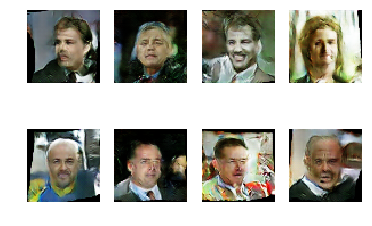

In [20]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

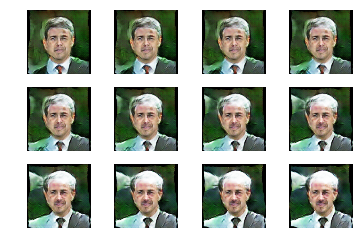

In [21]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.05
plt.show()